# Fraud Detection on Transactions
<hr>

In [1]:
# import functions
import sys
import os 
sys.path.append('../src')

from preprocessing import count_unique_numbers, generalize_categories
from load_data import load_data
from model import *

In [2]:
# Import General libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import libraries for preprocessing
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
from sklearn.pipeline import make_pipeline

# Import libraries for model building
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV

# Summary

Through this project, we attempted to build three classification models capable of distinguishing between fraud and non-fraud transactions, as indicated on customer accounts. The models we experimented with include logistic regression, random forest classifier, and gradient boost classifier. Due to an extreme imbalance in our data, we encountered challenges in developing an effective model in Milestone 1. The results of our experimented models are listed below. 

|                       | Logistic Regression    | Random Forest Classifier        |  Gradient Boost Classifier        |
| :-------------        | -----------------------: | -----------------------: | -----------------------: |
| **Train f1 Score** | 0.00623         | 0.0783              | 0.872 |
| **Test f1 Score**    | 0.00612         |   0.0732      | 0.0386                  |

To enhance the `f1` scores, we have provided suggestions in the discussion section. Potential improvements include incorporating frequency encoding through feature engineering, adjusting scoring metrics, and experimenting with more complex models. 

# Introduction

In recent times, credit card fraud has emerged as one of the most prevalent forms of fraudulent activities. According to [The Ascent](https://www.fool.com/the-ascent/research/identity-theft-credit-card-fraud-statistics/) the incidence of credit card fraud has seen a significant rise, escalating from 371,000 reports in 2017 to 1.4 million in 2021. To combat this surge in credit card fraud, corporations have turned to machine learning algorithms, employing them to automatically detect and filter fraudulent transactions. These models are trained on historical data to identify potential fraud.

This project is driven by the goal of constructing an effective fraud detection model to mitigate the occurrence of credit card frauds. The [Capital One Data Science Challenge](https://github.com/CapitalOneRecruiting/DS) dataset is utilized for building our model, consisting of 786,363 entries of synthetically generated data. Since all the data is synthetically generated, we ensure that customer confidentiality is maintained throughout the model-building process. 

# Methods & Results

## Read Dataset (Web)

In [3]:
# Imports to download dataset from 
# import json
# from zipfile import ZipFile
# from io import BytesIO
# from urllib.request import urlopen

In [4]:
url = "https://github.com/CapitalOneRecruiting/DS/blob/173ca4399629f1e4e74146107eb9bef1e7009741/transactions.zip?raw=true"

In [5]:
#resp = urlopen(url)
#myzip = ZipFile(BytesIO(resp.read()))

#data_list = []

#for line in myzip.open(myzip.namelist()[0]).readlines():
#    data_list.append(json.loads(line))
#df = pd.DataFrame(data_list)

In [6]:
# Saving raw_data to data folder
# raw_df.to_pickle('data/transactions.pkl.zip', compression='zip')

## Read Dataset (Local)

In [7]:
pd.__version__

'1.4.1'

In [8]:
pd.read_pickle('../data/transactions.pkl.zip', compression="infer")

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000.0,5000.00,2016-08-13T14:27:32,98.55,Uber,US,US,02,...,,0.00,,,,False,,,False,False
1,737265056,737265056,5000.0,5000.00,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,...,,0.00,,,,True,,,False,False
2,737265056,737265056,5000.0,5000.00,2016-11-08T09:18:39,7.47,Play Store,US,US,09,...,,0.00,,,,False,,,False,False
3,737265056,737265056,5000.0,5000.00,2016-12-10T02:14:50,7.47,Play Store,US,US,09,...,,0.00,,,,False,,,False,False
4,830329091,830329091,5000.0,5000.00,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,...,,0.00,,,,True,,,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786358,732852505,732852505,50000.0,48904.96,2016-12-22T18:44:12,119.92,Lyft,US,US,90,...,,1095.04,,,,False,,,False,False
786359,732852505,732852505,50000.0,48785.04,2016-12-25T16:20:34,18.89,hulu.com,US,US,09,...,,1214.96,,,,False,,,False,False
786360,732852505,732852505,50000.0,48766.15,2016-12-27T15:46:24,49.43,Lyft,US,US,02,...,,1233.85,,,,False,,,False,False
786361,732852505,732852505,50000.0,48716.72,2016-12-29T00:30:55,49.89,walmart.com,US,US,09,...,,1283.28,,,,False,,,False,False


In [9]:
df = load_data()

# EDA Analysis 

## 1. Basic Information Dataset Overview

In [10]:
df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000.0,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,...,,0.0,,,,False,,,False,False
1,737265056,737265056,5000.0,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,...,,0.0,,,,True,,,False,False
2,737265056,737265056,5000.0,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
3,737265056,737265056,5000.0,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
4,830329091,830329091,5000.0,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,...,,0.0,,,,True,,,False,False


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   accountNumber             786363 non-null  object 
 1   customerId                786363 non-null  object 
 2   creditLimit               786363 non-null  float64
 3   availableMoney            786363 non-null  float64
 4   transactionDateTime       786363 non-null  object 
 5   transactionAmount         786363 non-null  float64
 6   merchantName              786363 non-null  object 
 7   acqCountry                786363 non-null  object 
 8   merchantCountryCode       786363 non-null  object 
 9   posEntryMode              786363 non-null  object 
 10  posConditionCode          786363 non-null  object 
 11  merchantCategoryCode      786363 non-null  object 
 12  currentExpDate            786363 non-null  object 
 13  accountOpenDate           786363 non-null  o

## 2. Descriptive Statistics

In [12]:
df.describe()

,creditLimit,availableMoney,transactionAmount,currentBalance
count,786363.000000,786363.000000,786363.000000,786363.000000
mean,10759.464459,6250.725369,136.985791,4508.739089
std,11636.174890,8880.783989,147.725569,6457.442068
min,250.000000,-1005.630000,0.000000,0.000000
25%,5000.000000,1077.420000,33.650000,689.910000
50%,7500.000000,3184.860000,87.900000,2451.760000
75%,15000.000000,7500.000000,191.480000,5291.095000
max,50000.000000,50000.000000,2011.540000,47498.810000


## 3. Data Cleaning and Preprocessing Missing Values

In [13]:
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])
missing_values

Series([], dtype: int64)


accountNumber               0
customerId                  0
creditLimit                 0
availableMoney              0
transactionDateTime         0
transactionAmount           0
merchantName                0
acqCountry                  0
merchantCountryCode         0
posEntryMode                0
posConditionCode            0
merchantCategoryCode        0
currentExpDate              0
accountOpenDate             0
dateOfLastAddressChange     0
cardCVV                     0
enteredCVV                  0
cardLast4Digits             0
transactionType             0
echoBuffer                  0
currentBalance              0
merchantCity                0
merchantState               0
merchantZip                 0
cardPresent                 0
posOnPremises               0
recurringAuthInd            0
expirationDateKeyInMatch    0
isFraud                     0
dtype: int64

In [14]:
def count_empty_strings(column):
    return (column == '').sum()

# Apply this function to each column
empty_string_counts = df.apply(count_empty_strings)
print(empty_string_counts)

accountNumber                    0
customerId                       0
creditLimit                      0
availableMoney                   0
transactionDateTime              0
transactionAmount                0
merchantName                     0
acqCountry                    4562
merchantCountryCode            724
posEntryMode                  4054
posConditionCode               409
merchantCategoryCode             0
currentExpDate                   0
accountOpenDate                  0
dateOfLastAddressChange          0
cardCVV                          0
enteredCVV                       0
cardLast4Digits                  0
transactionType                698
echoBuffer                  786363
currentBalance                   0
merchantCity                786363
merchantState               786363
merchantZip                 786363
cardPresent                      0
posOnPremises               786363
recurringAuthInd            786363
expirationDateKeyInMatch         0
isFraud             

### 3.1 Drop columns with mostly empty strings(count > 70,000)

In [15]:
df.drop(['echoBuffer', 'merchantCity', 'merchantZip', 'posOnPremises', 'recurringAuthInd' ,'merchantState'], axis=1, inplace=True)


In [16]:
df.head(5)

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000.0,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,...,2015-03-14,2015-03-14,414,414,1803,PURCHASE,0.0,False,False,False
1,737265056,737265056,5000.0,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,...,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,True,False,False
2,737265056,737265056,5000.0,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,...,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,False,False,False
3,737265056,737265056,5000.0,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,...,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,False,False,False
4,830329091,830329091,5000.0,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,...,2015-08-06,2015-08-06,885,885,3143,PURCHASE,0.0,True,False,False


# 4. Data Preprocessing, Data Type Conversion, Cat encoding, missing value imputing

In [17]:
# Convert dates to datetime for plotting
df['transactionDateTime'] = pd.to_datetime(df['transactionDateTime'])

# 5. Data Visualization 

## 5.1 Numerical & Categorical Features visuals

numerical features
Index(['creditLimit', 'availableMoney', 'transactionAmount', 'currentBalance'], dtype='object')
categorical_features
Index(['accountNumber', 'customerId', 'merchantName', 'acqCountry',
       'merchantCountryCode', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'currentExpDate', 'accountOpenDate',
       'dateOfLastAddressChange', 'cardCVV', 'enteredCVV', 'cardLast4Digits',
       'transactionType', 'cardPresent', 'expirationDateKeyInMatch',
       'isFraud'],
      dtype='object')


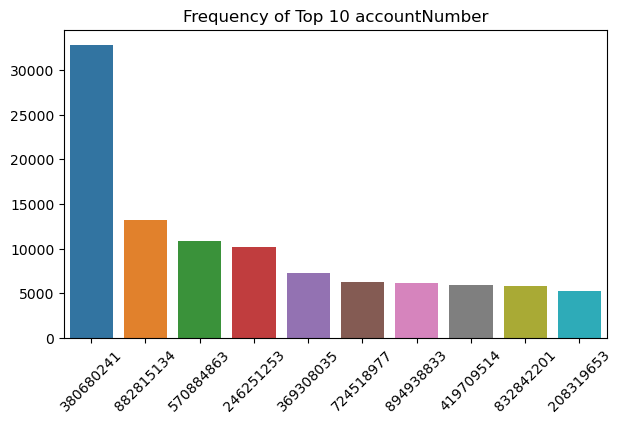

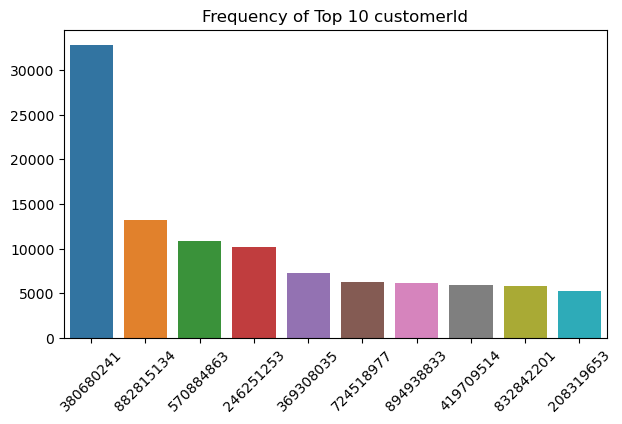

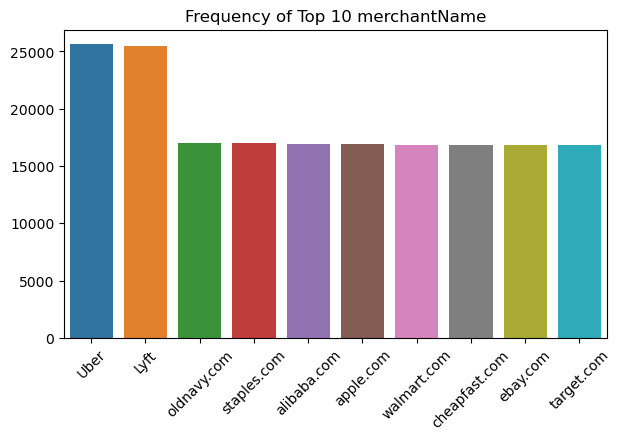

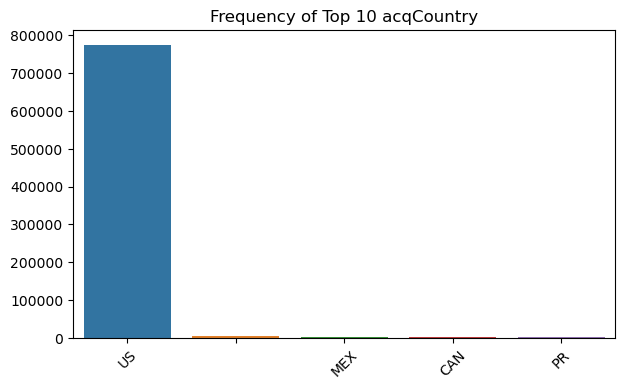

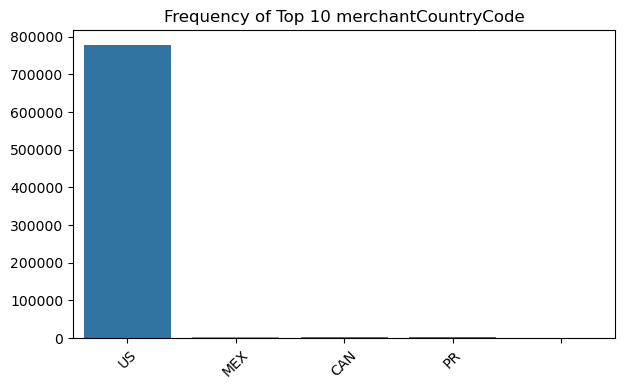

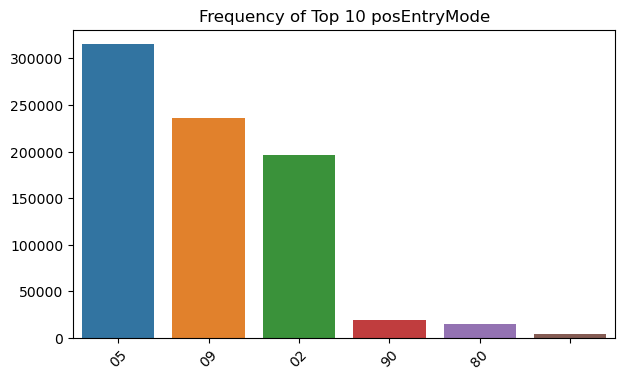

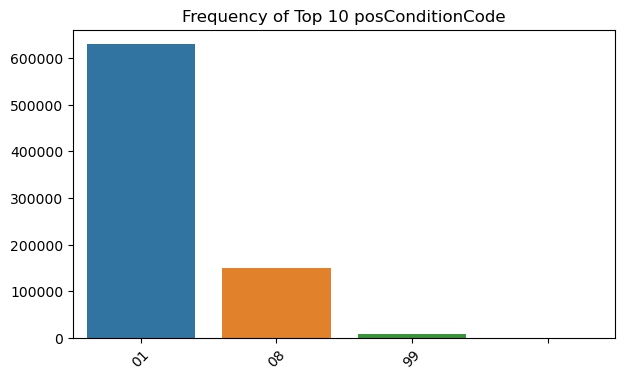

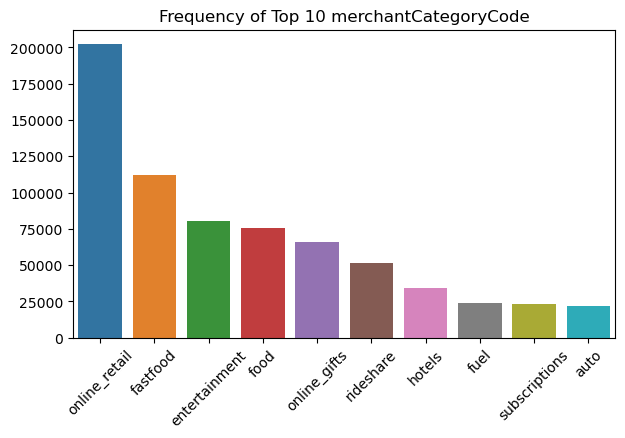

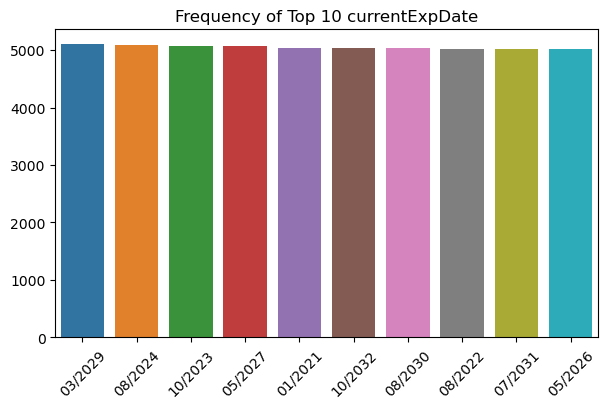

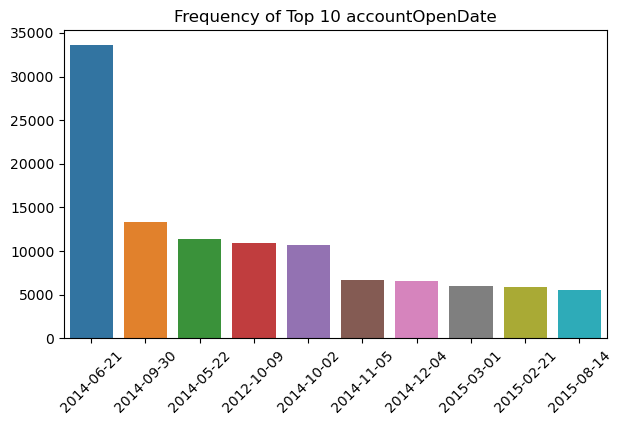

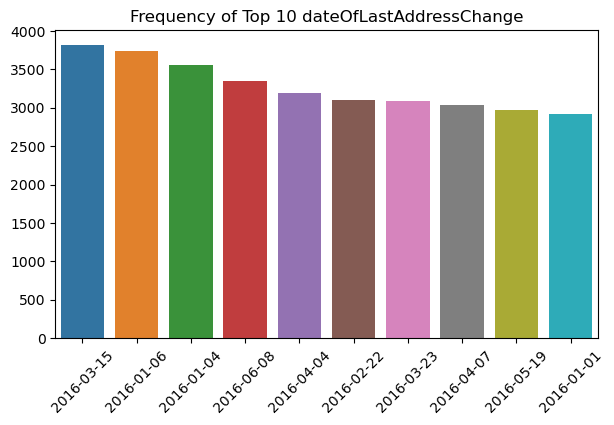

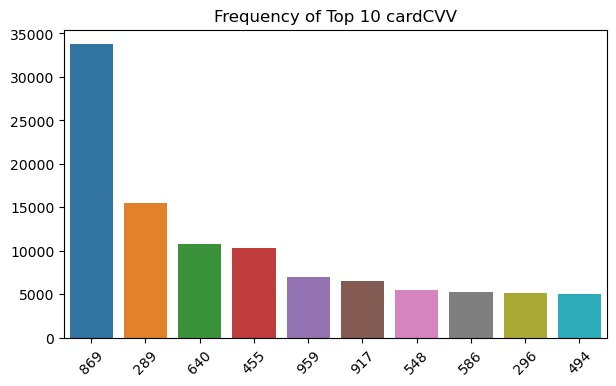

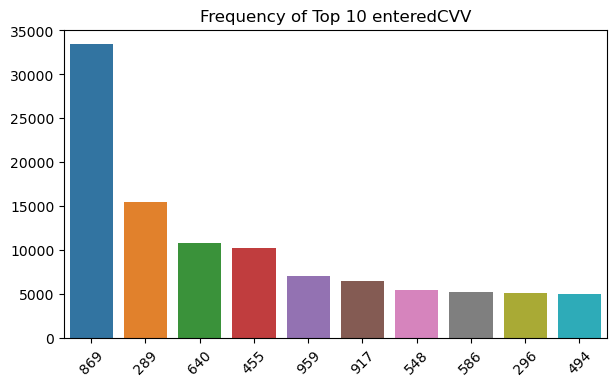

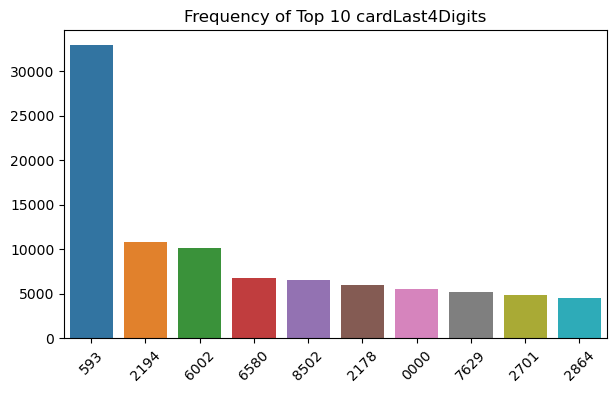

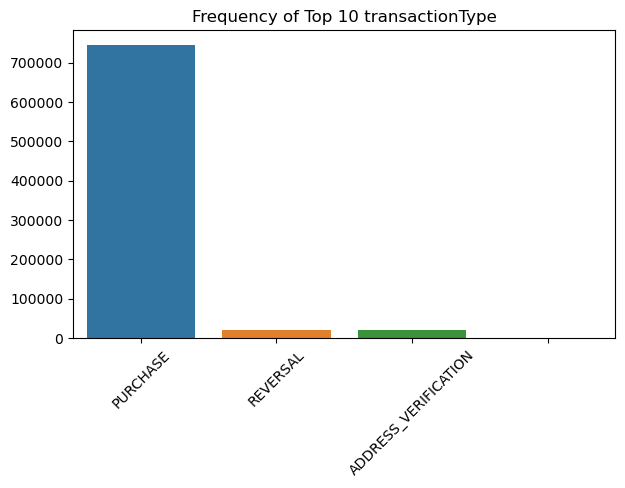

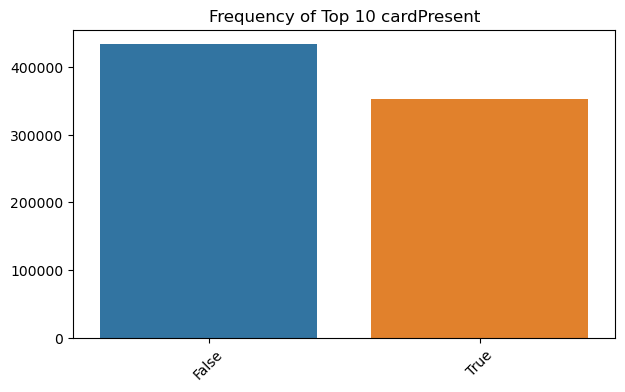

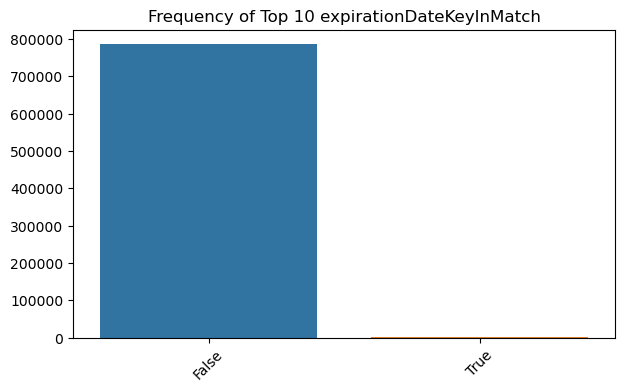

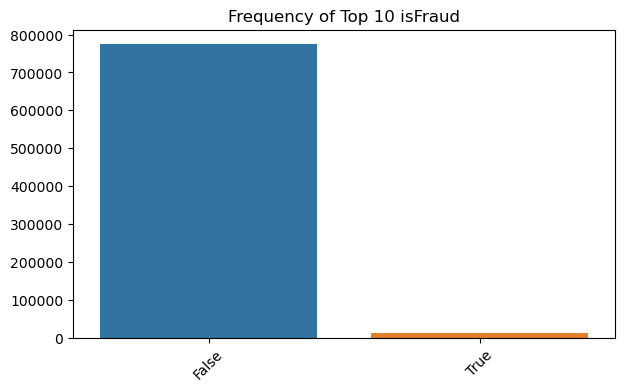

In [18]:
# 1. Histograms for Numerical Features
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
print('numerical features')
print(numerical_features)
categorical_features = df.select_dtypes(include=['object', 'bool']).columns
print('categorical_features')
print( categorical_features)

# 2. Bar Charts for Categorical Features
for col in categorical_features:
    counts = df[col].value_counts().nlargest(10)  # Taking the top 10 for brevity
    plt.figure(figsize=(7,4))
    sns.barplot(x=counts.index, y=counts.values)
    plt.title(f'Frequency of Top 10 {col}')
    plt.xticks(rotation=45)
    plt.show()

## 5.2 Outlier Detection with boxplots

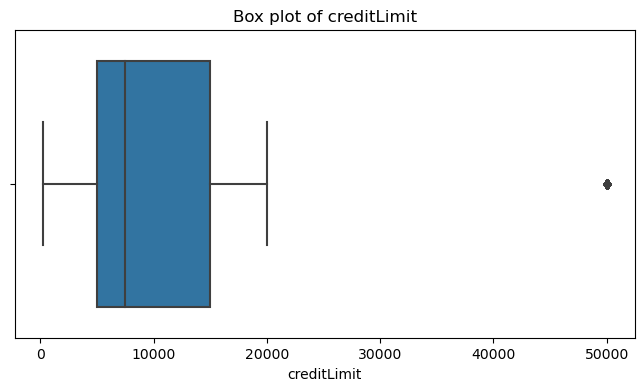

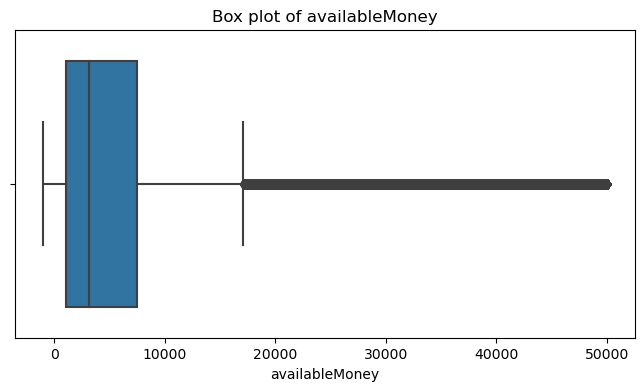

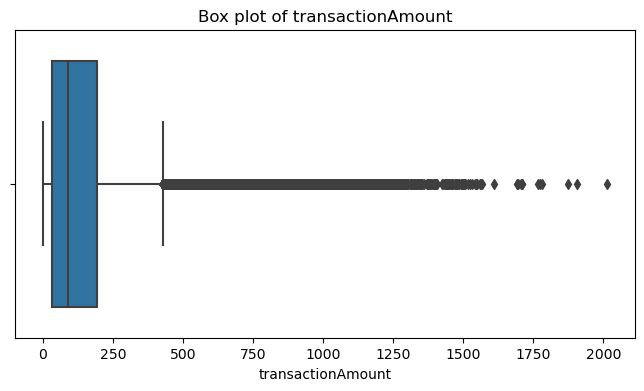

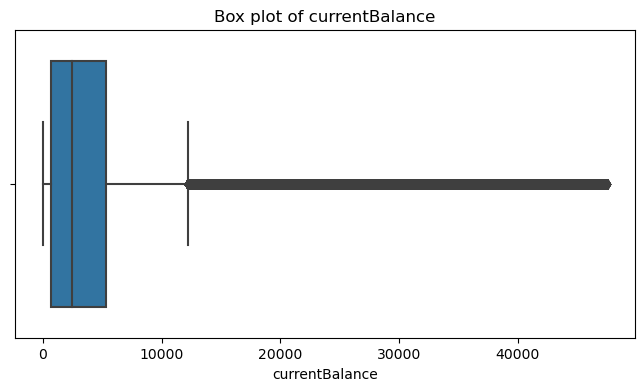

In [19]:
# 3. Box Plots for Numerical Features
for col in numerical_features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df, x=col)
    plt.title(f'Box plot of {col}')
    plt.show()

## 5.3 Time Series Analysis

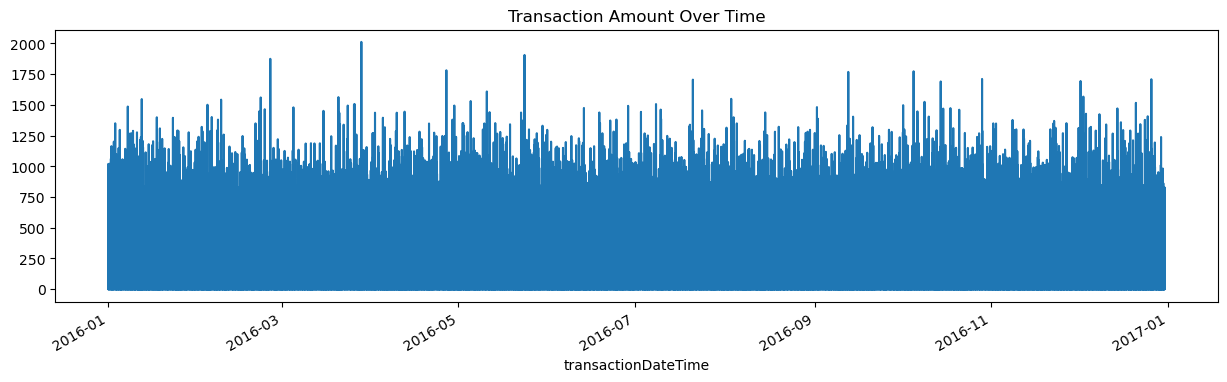

In [20]:
# 4. Time Series Plot
plt.figure(figsize=(15, 4))
df.set_index('transactionDateTime')['transactionAmount'].plot()
plt.title('Transaction Amount Over Time')
plt.show()

## 5.4 Correlation Analysis for Numerical Features


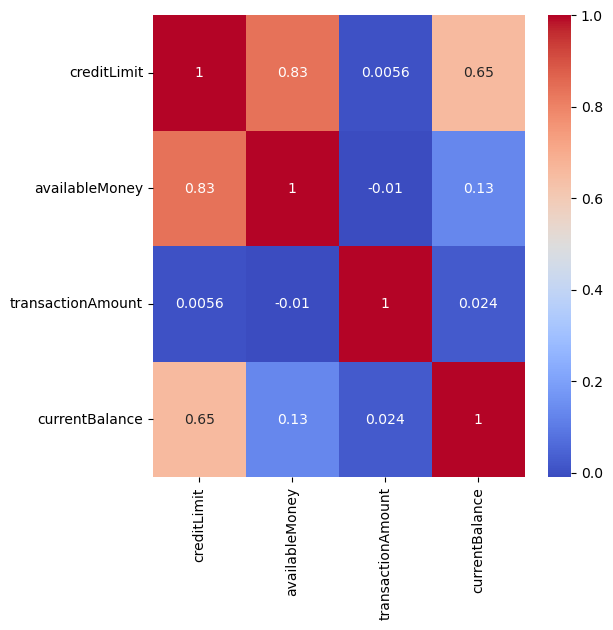

In [21]:
plt.figure(figsize=(6, 6))
sns.heatmap(df[numerical_features].corr(), annot=True, cmap='coolwarm')
plt.show()


# 6 Feature Engineering

We created a cvv matched feature to check if the entered cvv for the purchase is the same as card cvv

In [22]:
numerical_features = numerical_features.tolist()
categorical_features = categorical_features.tolist()

In [23]:
df["CVVmatched"] = df.cardCVV == df.enteredCVV
df = df.drop(["cardCVV", "enteredCVV"], axis=1)
categorical_features.remove("cardCVV")
categorical_features.remove("enteredCVV")
categorical_features.append("CVVmatched")

# 7 Preprocessing

In [24]:
display(df.head())
print("Number of columns:",len(df.columns.tolist()))
print("Number of numeric feature columns:",len(numerical_features))
print("Number of categorical feature columns:",len(categorical_features))

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,CVVmatched
0,737265056,737265056,5000.0,5000.0,2016-08-13 14:27:32,98.55,Uber,US,US,02,...,06/2023,2015-03-14,2015-03-14,1803,PURCHASE,0.0,False,False,False,True
1,737265056,737265056,5000.0,5000.0,2016-10-11 05:05:54,74.51,AMC #191138,US,US,09,...,02/2024,2015-03-14,2015-03-14,767,PURCHASE,0.0,True,False,False,True
2,737265056,737265056,5000.0,5000.0,2016-11-08 09:18:39,7.47,Play Store,US,US,09,...,08/2025,2015-03-14,2015-03-14,767,PURCHASE,0.0,False,False,False,True
3,737265056,737265056,5000.0,5000.0,2016-12-10 02:14:50,7.47,Play Store,US,US,09,...,08/2025,2015-03-14,2015-03-14,767,PURCHASE,0.0,False,False,False,True
4,830329091,830329091,5000.0,5000.0,2016-03-24 21:04:46,71.18,Tim Hortons #947751,US,US,02,...,10/2029,2015-08-06,2015-08-06,3143,PURCHASE,0.0,True,False,False,True


Number of columns: 22
Number of numeric feature columns: 4
Number of categorical feature columns: 17


In [25]:
len(df["transactionDateTime"].unique().tolist())

776637

We have included all columns as our features except for `transactionDateTime`, which is a `datetime` column. As seen from the above, the number of unique values in `transactionDateTime` is 776637; thus, this will be dropped.

In [26]:
drop_features = ["transactionDateTime"]

In [27]:
categorical_features.remove("isFraud")

In [28]:
# Account number and customer id columns are redundant.
print((df.accountNumber == df.customerId).all())
df = df.drop("customerId", axis=1)
categorical_features.remove("customerId")

True


In [29]:
# We decided to drop merchantName column because it vastly increased our feature space. 
# Without adding much information. merchantCategoryCode will be used to categorize merchants.
df = df.drop("merchantName", axis=1)
categorical_features.remove("merchantName")

In [30]:
df = df.drop(["accountOpenDate", 'cardLast4Digits'], axis=1)
categorical_features.remove("accountOpenDate")
categorical_features.remove("cardLast4Digits")

`isFraud` is our target variable, hence removed from `categorical_features` list.

In [31]:
print(f"Numerical Features: {numerical_features}\n")
print(f"Categorical Features: {categorical_features}")

Numerical Features: ['creditLimit', 'availableMoney', 'transactionAmount', 'currentBalance']

Categorical Features: ['accountNumber', 'acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode', 'merchantCategoryCode', 'currentExpDate', 'dateOfLastAddressChange', 'transactionType', 'cardPresent', 'expirationDateKeyInMatch', 'CVVmatched']


### 7.1 Preprocessing Categorical Features

In [32]:
# Using imported function from src/preprocessing.py
count_unique_numbers(df, categorical_features)

,feature,unique_entry_counts
0,accountNumber,5000
7,dateOfLastAddressChange,2184
6,currentExpDate,165
5,merchantCategoryCode,19
3,posEntryMode,6
1,acqCountry,5
2,merchantCountryCode,5
4,posConditionCode,4
8,transactionType,4
9,cardPresent,2


We have seen way too many unique entries for a few categorical features, including `accountNumber` and `customerId`. Thus we will apply a function to narrow down the number of unique entries; once the number of unique entries in a column is **greater than 10**, `generalize_categories` function will classify entries that appear less than 10% in our dataset as "Others". 

In [33]:
# Using imported function from src/preprocessing.py
preprocess_df = df.copy()
for category_column in categorical_features:
    preprocess_df[category_column] = preprocess_df[category_column].replace('', 'Other')
    if len(preprocess_df[category_column].unique().tolist()) > 10:
        preprocess_df = generalize_categories(category_column, preprocess_df)

In [34]:
preprocess_df

,accountNumber,creditLimit,availableMoney,transactionDateTime,transactionAmount,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,dateOfLastAddressChange,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,CVVmatched,frequency
0,Other,5000.0,5000.00,2016-08-13 14:27:32,98.55,US,US,02,01,rideshare,Other,Other,PURCHASE,0.00,False,False,False,True,0.000563
1,Other,5000.0,5000.00,2016-10-11 05:05:54,74.51,US,US,09,01,entertainment,Other,Other,PURCHASE,0.00,True,False,False,True,0.000563
2,Other,5000.0,5000.00,2016-11-08 09:18:39,7.47,US,US,09,01,mobileapps,Other,Other,PURCHASE,0.00,False,False,False,True,0.000563
3,Other,5000.0,5000.00,2016-12-10 02:14:50,7.47,US,US,09,01,mobileapps,Other,Other,PURCHASE,0.00,False,False,False,True,0.000563
4,Other,5000.0,5000.00,2016-03-24 21:04:46,71.18,US,US,02,01,fastfood,Other,Other,PURCHASE,0.00,True,False,False,True,0.000094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786358,Other,50000.0,48904.96,2016-12-22 18:44:12,119.92,US,US,90,01,rideshare,Other,Other,PURCHASE,1095.04,False,False,False,True,0.000140
786359,Other,50000.0,48785.04,2016-12-25 16:20:34,18.89,US,US,09,01,online_subscriptions,Other,Other,PURCHASE,1214.96,False,False,False,True,0.000140
786360,Other,50000.0,48766.15,2016-12-27 15:46:24,49.43,US,US,02,01,rideshare,Other,Other,PURCHASE,1233.85,False,False,False,True,0.000140
786361,Other,50000.0,48716.72,2016-12-29 00:30:55,49.89,US,US,09,99,online_retail,Other,Other,PURCHASE,1283.28,False,False,False,True,0.000140


In [35]:
count_unique_numbers(preprocess_df, categorical_features)

,feature,unique_entry_counts
5,merchantCategoryCode,16
3,posEntryMode,6
0,accountNumber,5
1,acqCountry,5
2,merchantCountryCode,5
4,posConditionCode,4
8,transactionType,4
9,cardPresent,2
10,expirationDateKeyInMatch,2
11,CVVmatched,2


From above data frame, we observed that none of the entires in `currentExpDate` and `dateOfLastAddressChange` has frequency of 10% or higher. We decided to drop the two columns as they seem to carry little to no predictive power.

In [36]:
categorical_features.remove("currentExpDate")
categorical_features.remove("dateOfLastAddressChange")
drop_features.append("currentExpDate")
drop_features.append("dateOfLastAddressChange")

### 7.2 Preprocessing Numerical Columns

As seen from the distribution of numerical columns above (refer to the boxplots), we can see that `creditLimit` column has a single outlier, whereas the other columns have multiple outliers. To intrapolate the missing values, we decided to use `strategy="median"` for the other columns, and `strategy="mean"` for `creditLimit`. This decision stems from the fact that median is a measure of central tendency that is more robust to outliers. Thus, we will be building two separate `SimpleImputer()` for each of mean and median strategies.

In [37]:
numerical_features.remove("creditLimit")
credit_feature = ["creditLimit"]

In [38]:
train_df, test_df = train_test_split(preprocess_df, test_size=0.2, random_state=522)
X_train, y_train = train_df.drop(["isFraud"], axis=1), train_df["isFraud"]
X_test, y_test = test_df.drop(["isFraud"], axis=1), test_df["isFraud"]

In [39]:
ct = make_column_transformer(
    (
        make_pipeline(SimpleImputer(strategy="median"), StandardScaler()),
        numerical_features,
    ),
    (
        make_pipeline(SimpleImputer(strategy="mean"), StandardScaler()),
        credit_feature,
    ),
    (OneHotEncoder(drop="if_binary", handle_unknown="ignore"), categorical_features),
    ("drop", drop_features)
)

transformed_df = ct.fit_transform(X_train)
transformed_df

<629090x52 sparse matrix of type '<class 'numpy.float64'>'
	with 7827026 stored elements in Compressed Sparse Row format>

In [40]:
column_names = (
    numerical_features
    + credit_feature
    + ct.named_transformers_["onehotencoder"].get_feature_names_out().tolist()
)
print(len(column_names))

52


In [41]:
transformed_X_train = pd.DataFrame(transformed_df.toarray(), columns=column_names)
transformed_X_train

,availableMoney,transactionAmount,currentBalance,creditLimit,accountNumber_246251253,accountNumber_380680241,accountNumber_570884863,accountNumber_882815134,accountNumber_Other,acqCountry_CAN,...,merchantCategoryCode_personal care,merchantCategoryCode_rideshare,merchantCategoryCode_subscriptions,transactionType_ADDRESS_VERIFICATION,transactionType_Other,transactionType_PURCHASE,transactionType_REVERSAL,cardPresent_True,expirationDateKeyInMatch_True,CVVmatched_True
0,-0.505378,-0.821477,-0.196817,-0.494840,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
1,0.092375,-0.870402,-0.630626,-0.280071,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,-0.164150,-0.311119,-0.665029,-0.494840,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3,-0.678751,1.888795,-0.577148,-0.838470,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
4,-0.610822,2.160418,-0.438522,-0.709609,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629085,-0.461043,-0.721733,-0.257650,-0.494840,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
629086,0.854799,-0.686410,-0.517607,0.364235,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
629087,-0.659082,0.067962,0.014087,-0.494840,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
629088,-0.405422,-0.677478,-0.333970,-0.494840,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


In [42]:
transformed_df_test = ct.transform(X_test)
transformed_X_test = pd.DataFrame(transformed_df_test.toarray(), columns=column_names)

In [43]:
credit_feature

['creditLimit']

In [44]:
drop_features

['transactionDateTime', 'currentExpDate', 'dateOfLastAddressChange']

In [45]:
numerical_features

['availableMoney', 'transactionAmount', 'currentBalance']

In [46]:
credit_feature

['creditLimit']

In [47]:
categorical_features

['accountNumber',
 'acqCountry',
 'merchantCountryCode',
 'posEntryMode',
 'posConditionCode',
 'merchantCategoryCode',
 'transactionType',
 'cardPresent',
 'expirationDateKeyInMatch',
 'CVVmatched']

# Modeling

For the modelling phase we will do cross validation on three different model algorithms. Logistic regression, random forest and gradient boosting classifier. We will first try logistic regression as it is the model with the least compexity. As it is a linear model it might fail to capture non-linear relationships between the features and our target variable. We will increase the complexity first with random forest and then gradient boosting classifier and check if using more complex models increase our test scores. 

Out feature space is quite large as we have more than 50 features. But with more than 500,000 data points in our training set we think our models can handle 50+ features.

In [48]:
# # helper function to display roc-auc scores and confusion matrices of train and test sets
# def create_conf_matrix(clf, X_train, y_train, X_test, y_test):
#     X_train_pred = clf.predict(X_train)
#     conf_matrix = pd.crosstab(X_train_pred, y_train)
#     conf_matrix.index.name = "prediction"
#     print("Train confusion matrix:")
#     display(conf_matrix)
#     print("Train f1 score:",f1_score(X_train_pred, y_train))
#     print("----")
#     X_test_pred = clf.predict(X_test)
#     conf_matrix2 = pd.crosstab(X_test_pred, y_test)
#     conf_matrix2.index.name = "prediction"
#     print("Test confusion matrix:")
#     display(conf_matrix2)
#     print("Test f1 score:",f1_score(X_test_pred, y_test))

### Logistic Regression

In [49]:
# param_dist_logreg = {"logisticregression__C": 10.0 ** np.arange(-2, 3),
#                      "logisticregression__solver": ["newton-cholesky", "lbfgs"]}
# logreg_search = run_model_with_random_search(
#     X_train, y_train, numerical_features, credit_feature, categorical_features, 
#     drop_features, LogisticRegression, param_dist_logreg)
# logreg_search.fit(X_train, y_train)


In [50]:
# pd.DataFrame(logreg_search.cv_results_)[["rank_test_score", 'mean_test_score', 'mean_train_score', 
#                                          "param_logisticregression__C", "param_logisticregression__solver", 
#                                          "mean_fit_time"]].sort_values("rank_test_score").set_index("rank_test_score")



In [51]:
# print("Confusion matrix for train data:")
# ConfusionMatrixDisplay.from_estimator(logreg_search,X_train,y_train, values_format='d')

In [52]:
# print("Confusion matrix for test data:")
# ConfusionMatrixDisplay.from_estimator(logreg_search,X_test,y_test, values_format='d')

In [53]:
# train_scores = []
# test_scores = []
# C_list = 10.0 ** np.arange(-10, 4)
# for c in C_list:
#     pipe = make_pipeline(ct, LogisticRegression(class_weight = "balanced", C=c))
#     pipe.fit(X_train, y_train)
#     X_train_pred = pipe.predict(X_train)
#     train_scores.append(f1_score(X_train_pred, y_train))
#     X_test_pred = pipe.predict(X_test)
#     test_scores.append(f1_score(X_test_pred, y_test))
#     print(f"{c} done")

In [54]:
# plt.plot(C_list, train_scores, label='train score')
# plt.plot(C_list, test_scores, label='test score')
# plt.xscale("log")
# # Adding a legend
# plt.legend()

# # Display the plot
# plt.show()

### Random Forest Classifier

In [55]:
# param_dist_rfclf = {"randomforestclassifier__n_estimators": 50 * np.array([1, 2, 4]),
#                    "randomforestclassifier__max_depth": [5, 10, 20, None],
#                    "randomforestclassifier__max_features": ['sqrt', 'log2']}
# rfclf_search = run_model_with_random_search(
#     X_train, y_train, numerical_features, credit_feature, categorical_features, 
#     drop_features, RandomForestClassifier, param_dist_rfclf)
# rfclf_search.fit(X_train, y_train)

In [56]:
# pd.DataFrame(rfclf_search.cv_results_)[["rank_test_score", 'mean_test_score', 'mean_train_score', 
#                                          "param_randomforestclassifier__n_estimators", "param_randomforestclassifier__max_depth",
#                                          "param_randomforestclassifier__max_features", 
#                                          "mean_fit_time"]].sort_values("rank_test_score").set_index("rank_test_score")


In [57]:
# create_conf_matrix(rfclf_search, X_train, y_train, X_test, y_test)

In [58]:
# train_scores = []
# test_scores = []
# max_depths = [10, 20, 40, 100, None]
# for max_depth in max_depths:
#     pipe = make_pipeline(ct, RandomForestClassifier(class_weight = "balanced", max_depth=max_depth))
#     pipe.fit(X_train, y_train)
#     X_train_pred = pipe.predict(X_train)
#     train_scores.append(f1_score(X_train_pred, y_train))
#     X_test_pred = pipe.predict(X_test)
#     test_scores.append(f1_score(X_test_pred, y_test))
#     print(f"{max_depth} done")

The plot below shows train and test scores as we increase model complexity by changing max_depth argument

In [59]:
# plt.plot(max_depths, train_scores, label='train score')
# plt.plot(max_depths, test_scores, label='test score')
# # Adding a legend
# plt.legend()

# # Display the plot
# plt.show()

### Gradient Boosting Classifier

In [60]:
# param_dist_gbclf = {"gradientboostingclassifier__n_estimators": 50 * np.array([1, 2, 4]),
#                    "gradientboostingclassifier__max_depth": [3, 5, 10],
#                    "gradientboostingclassifier__learning_rate": [0.05, 0.1, 0.2]}
# gbclf_search = run_model_with_random_search(
#     X_train, y_train, numerical_features, credit_feature, categorical_features, 
#     drop_features, GradientBoostingClassifier, param_dist_gbclf, need_class_weights=False)
# gbclf_search.fit(X_train, y_train)

In [61]:
# pd.DataFrame(gbclf_search.cv_results_)[["rank_test_score", 'mean_test_score', 'mean_train_score', 
#                                          "param_gradientboostingclassifier__n_estimators", "param_gradientboostingclassifier__max_depth",
#                                          "param_gradientboostingclassifier__learning_rate", 
#                                          "mean_fit_time"]].sort_values("rank_test_score").set_index("rank_test_score")


In [62]:
# create_conf_matrix(gbclf_search, X_train, y_train, X_test, y_test)

# Discussion

In our effort to distinguish between fraudulent and non-fraudulent transactions in customer accounts, we evaluated three classification models: Logistic Regression, Random Forest Classifier, and Gradient Boost Classifier. The primary challenge was the extreme imbalance in our dataset.

**Conclusion**: 

Based on the provided confusion matrices and F1 scores for the train and test sets, it is evident that there is a discrepancy in the performance of the machine learning model between the training and testing phases. For the training set, the model achieved an F1 score of 0.6024, which is a moderate score indicating a reasonable balance between precision and recall for the fraud class. However, the test set's F1 score dropped significantly to 0.0343, suggesting that the model is not generalizing well to unseen data.

The confusion matrix for the training data shows that the model identified a considerable number of true positives (4334) but also misclassified a significant number of non-fraud cases as fraud (5607). In contrast, the test confusion matrix reveals that while the model was conservative in predicting fraud (only 58 true positives), it also produced a large number of false negatives (2418), indicating many fraudulent transactions were not detected.

Given these results, the selection of Logistic Regression over other models like Random Forest and Gradient Boost Classifier can be justified by its better performance in the training phase and its simplicity, which makes it easier to interpret and implement. Logistic Regression's linear nature allows for a clear understanding of feature importance and the relationship between variables, which could be beneficial for further tuning and transparency in fraud detection systems.

However, the stark difference between training and testing performance needs to be addressed. It is possible that Logistic Regression, despite its relative simplicity, is overfitting the training data and not capturing the underlying patterns that generalize to the test data. This situation calls for a more in-depth analysis of feature selection, potential regularization techniques to prevent overfitting, and the exploration of model ensembling or more sophisticated algorithms that could yield a better balance between bias and variance. Furthermore, it would be beneficial to explore and adjust the threshold for classification to improve sensitivity to fraud detection on the test set.

1. **Data Preprocessing and EDA (Exploratory Data Analysis)**

Data preprocessing is a vital step before introducing data into a machine learning model. EDA allowed us to scrutinize our features and determine appropriate methods for imputing missing values, processing numerical features, and transforming categorical features. Many columns had a significant portion of missing values; thus, removing these columns improved performance and reduced the risk of overfitting. For categorical features, we implemented one-hot encoding for binary categories and label encoding for those with more than two values, thus preventing the generation of excessive features and overfitting.

2. **Handling Imbalanced Data**

Addressing imbalanced data is challenging, particularly when non-fraudulent transactions significantly outnumber fraudulent ones. We used undersampling to reduce the size of the majority class, creating a balanced dataset for model training. This approach is crucial for models that typically do not generalize well on imbalanced datasets.

3. **Model Selection and Evaluation**

We applied cross-validation to three classification algorithms: Logistic Regression, Random Forest, and Gradient Boosting Classifier. Each model was chosen for its increasing complexity, allowing us to evaluate if more complex models enhance our ability to detect fraud.

   - *Logistic Regression*: We began with Logistic Regression due to its simplicity. However, as a linear model, it may not effectively capture complex, non-linear relationships.

   - *Random Forest*: We then progressed to the Random Forest Classifier, an ensemble method adept at detecting non-linear patterns.

   - *Gradient Boosting Classifier*: Lastly, we used the Gradient Boosting Classifier for its advanced boosting technique, aiming to refine predictive performance.

   - *Results*: Logistic Regression showed limited success, indicating the need for more complex models. Random Forest improved f1 scores but suggested potential underfitting. The Gradient Boost Classifier excelled in training but underperformed in testing, implying overfitting.

4. **Analysis of Model Performance**

The extreme imbalance in our data, with scarce instances of fraud, posed a significant challenge. This imbalance often leads to models that favor the majority class, resulting in poor performance in detecting fraud.

5. **Method**
 **Oversampling the Minority Class**: To counteract the imbalance between the high volume of non-fraudulent transactions and the relatively low incidence of fraudulent ones, we employed oversampling. This technique specifically focused on increasing the representation of the minority class (fraudulent transactions) in our dataset.

**Using Synthetic Minority Over-sampling Technique (SMOTE)**: As part of our oversampling strategy, we implemented SMOTE. This advanced technique generates synthetic but realistic samples of fraudulent transactions. By doing so, it aids in creating a more balanced dataset that better represents the characteristics of both classes.

**Data Preprocessing**: Prior to model training, we undertook rigorous data preprocessing. This included cleaning the data, handling missing values, and appropriately encoding categorical variables to ensure that the dataset was well-suited for effective model training.

**Model Training and Evaluation**: We trained various machine learning models on this balanced dataset. Our selection of models included those that are commonly effective in classification tasks, such as Logistic Regression, Random Forest, and Gradient Boosting Classifirs.

 **Cross-validation and Hyperparameter Tuning**: To ensure robustness and optimize performance, we utilized cross-validation techniques and conducted hyperparameter tuning for each model. This step was crucial to find the optimal settings for each classifier and to avoid issues like overfitting or underfitting.

**Performance Assessment**: We assessed the performance of each model using metrics suitable for imbalanced classification problems, such as the F1 score, precision-recall curve, and AUC-ROC curve. These metrics helped us in evaluating the models' ability to accurately identify fraudulent tran
   
6. **Future Directions and Improvements**  *

Our preliminary investigations highlight the need for further model refinement. Our plans include:

   - *Resampling Techniques*: We will explore oversampling of the minority class (fraudulent transactions) using methods like SMOTE for synthetic sample generation.

   - *Feature Engineering*: We aim to incorporate frequency encoding, particularly for 'merchant_name', to improve model sensitivity to potential fraud indicators.

   - *Adjusting Classification Threshold*: We plan to experiment with different thresholds to optimize the precision-recall balance.

   - *Scoring Metrics*: Given the importance of recall, we will prioritize it in our evaluations while also considering precision. This includes experimenting with precision-recall curves and alternative loss functions such as 'Weighted Cross-Entropy' and 'Focal Loss', tailored for imbalanced datasets.

   - *AUC-ROC Curve Metrics*: We are considering adopting AUC-ROC curve metrics for a more comprehensive evaluation, particularly effective in imbalanced datasets.

7. **Model Complexity and Resource Management**

We will explore more complex models or ensemble methods, such as neural networks, to capture intricate data patterns. However, we will prioritize resource efficiency in model productionization.

# References

Capital One. (2018). Capital One Data Science Challenge. In CapitalOneRecruiting GitHub Repository. https://github.com/CapitalOneRecruiting/DS

Python Software Foundation. Python Language Reference, version 3.11.6. Available at http://www.python.org

Timbers, T., Lee, M. & Ostblom, J. (2023). Breast Cancer Predictor. https://github.com/ttimbers/breast_cancer_predictor_py/tree/0.0.1

Pedregosa, F., Varoquaux, Ga"el, Gramfort, A., Michel, V., Thirion, B., Grisel, O., … others. (2011). Scikit-learn: Machine learning in Python. Journal of Machine Learning Research, 12(Oct), 2825–2830

McKinney, W., & others. (2010). Data structures for statistical computing in python. In Proceedings of the 9th Python in Science Conference (Vol. 445, pp. 51–56).

Caporal, J. (2023). Identity Theft and Credit Card Fraud Statistics for 2023. In the Ascent. https://www.fool.com/the-ascent/research/identity-theft-credit-card-fraud-statistics/